# Assignment — Link prediction

In [141]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import requests
import networkx as nx
from tqdm.notebook import tqdm
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import numpy as np
import random 

### Task 1. Dataset for link prediction (2 points)

Consider link prediction on the [e-mails network](http://snap.stanford.edu/data/email-Eu-core-temporal.html) where nodes are members of a research institution and edges are e-mails given with timestamps. The goal is to predict occurrence of edges in the test time period using information from the train time period only.

In [2]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/email-Eu-core-temporal.txt'
open('email-Eu-core-temporal.txt', 'wb').write(requests.get(url).content);


In [3]:
email_df = pd.read_csv(
    'email-Eu-core-temporal.txt', 
    delimiter=' ', 
    names=['sender', 'receiver', 'timestamp']
)
email_df

,sender,receiver,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926
...,...,...,...
332329,324,367,45401817
332330,790,126,45402441
332331,790,126,45403709
332332,782,126,45404903


Next, consider the following preprocessing procedure:
1. Select edges by given train and test time periods, for example, [0, 1000) is train and [1000, 2000) is test
2. Build a _core_ — a connected network where every edge occurs at least $k_\text{train}$ times in the train time period or at least $k_\text{test}$ times in the test time period. Let the core be undirected, so occurrences edges (1, 0) and (0, 1) are computed together.
3. From the core, select a train set of edges $E_\text{train}$ that occur for the first time in the train period. All others are included to $E_\text{test}$.
3. Exclude test edges that contain nodes that do not occur in train edges.

Write a function `train_test_edges` that takes a pd.DataFrame `email_df` with e-mail network, a tuple with the train time period borders `train_period`, say, (0, 1000), a similar tuple `test_period`, the number of edges occurrences `ktrain` and `ktest`. The function returns two lists with tuples — train and test edges. Every edge is returned of the form where the first node is less than the second, for example [(1, 2), (2, 3)] is ok, but [(2, 1), (3, 2)] is wrong.

In [212]:
def train_test_edges(email_df, train_period, test_period, ktrain, ktest):
    
    email_temp = email_df.copy()
    email_temp = email_temp[
        (train_period[0] <= email_temp.timestamp) 
        & (email_temp.timestamp < test_period[1])
    ]
    email_temp['from'] = email_temp[['sender', 'receiver']].min(axis=1)
    email_temp['to'] = email_temp[['sender', 'receiver']].max(axis=1)
    email_temp = email_temp.drop(['sender', 'receiver'], axis=1)
    email_temp = email_temp.set_index(['from', 'to'])

    email_train = email_temp[email_temp.timestamp < train_period[1]]
    email_train = email_train.groupby(['from', 'to']).count()
    train_core = email_train[email_train.timestamp >= ktrain].index.tolist()

    email_test = email_temp[test_period[0] <= email_temp.timestamp]
    email_test = email_test.groupby(['from', 'to']).count()
    test_core = email_test[email_test.timestamp >= ktest].index.tolist()

    train_list = []
    test_list = []
    core = list(set(train_core + test_core))
    for element in core:
      if ((element[0],element[1]) in email_train.index):
        train_list.append((element[0],element[1]))
      else:
        test_list.append((element[0],element[1])) 
    nodes_t1 = set([item for t in train_list for item in t])
    nodes_t2 = set([item for t in test_list for item in t])
    diff = nodes_t2.difference(nodes_t1) 
    final_test_edge = []
    for edge in test_list:
      if ((edge[0] not in diff) and (edge[1]  not in diff)):
        final_test_edge.append((edge[0],edge[1]))
    return train_list, final_test_edge
    # YOUR CODE HERE/
    #raise NotImplementedError()

In [214]:
train_pos, test_pos = train_test_edges(email_df, (1e7, 2e7), (2e7, 2.5e7), 4, 2)
_train_pos, _test_pos = np.array(train_pos), np.array(test_pos)
assert np.all(_train_pos[:, 0] < _train_pos[:, 1])
assert np.all(_test_pos[:, 0] < _test_pos[:, 1])
assert len(set(train_pos).intersection(test_pos)) == 0
assert _train_pos.shape == (3880, 2)
assert _test_pos.shape == (720, 2)

### Task 2. Negative sampling (2 points)

Usually, graphs are sparse, so there is the high imbalance between existent (positive) edges and nonexistent (negative) edges. Since the link prediction can be considered as a classification problem, the imbalance leads to the high misclassification. To eliminate this problem, we can use the negative sampling techniques, that is using only a some random part of negative edges in training.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/pos_neg_edges.png' width=500>

The simplest sampling strategy is to copy positive edges and randomly replace one node checking they do not occur in positive set and they are not self-loops. Let the negative set be the same size as the positive.

The `negative_sampling` function samples the unexisted edges from the graph. It takes list of train and test positive edges and returns train and test negative edges.

In [116]:
def negative_sampling(train_pos, test_pos):
    train_neg = []
    test_neg =[]
    list_positive_edges = train_pos + test_pos
    list_nodes = list(set([item for t in list_positive_edges for item in t]))
    for  i in range (0,len(train_pos)):
      fnode = train_pos[i][0]
      snode = train_pos[i][1]
      foundvalue = False
      while (foundvalue == False):
        snode = random.choice(list_nodes)
        if fnode < snode:
          if (fnode , snode)  not in list_positive_edges:
            if (fnode , snode) not in train_neg:
              foundvalue = True
      train_neg.append((fnode,snode))
    for j in range (0,len(test_pos)):
      fnode = test_pos[j][0]
      snode = test_pos[j][1]
      foundvalue = False
      while (foundvalue == False):
        snode = random.choice(list_nodes)
        if fnode < snode:
          #not a positive edge
          if (fnode , snode)  not in list_positive_edges:
            #not in train edges
            if (fnode , snode) not in train_neg:
              #not in test edges
              if (fnode,snode) not in test_neg:
                foundvalue = True
      test_neg.append((fnode,snode))
    return train_neg,test_neg
    # YOUR CODE HERE
    #raise NotImplementedError()

In [117]:
train_neg, test_neg = negative_sampling(train_pos, test_pos)
neg_edges = train_neg + test_neg
pos_edges = train_pos + test_pos
assert len(train_neg) == len(train_pos)
assert len(test_neg) == len(test_neg)
# negative edges has nodes from only positive edges
assert len(set(np.unique(neg_edges)).difference(np.unique(pos_edges))) == 0
# source nodes are the same
assert np.all(np.array(pos_edges)[:, 0] == np.array(neg_edges)[:, 0])
# no edges in both
assert len(set(pos_edges) & set(neg_edges)) == 0
# reversed negative edges are not positive
reversed_neg_edges = [(v, u) for u, v in neg_edges]
assert len(set(pos_edges) & set(reversed_neg_edges)) == 0

Form train and test pairs of nodes that contain positive and negative edges:
* $X_\text{train}, X_\text{test}$ — pairs of nodes, contains positive and negative edges
* $y_\text{train}, y_\text{test}$ — labels of pairs, 1 is positive, 0 is negative

In [118]:
x_train = np.random.permutation(train_pos + train_neg)
y_train = [int((u, v) in train_pos) for (u, v) in x_train]

x_test = np.random.permutation(test_pos + test_neg)
y_test = [int((u, v) in test_pos) for (u, v) in x_test]
y_test[:10]

[0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

### Task 3. Prediction by similarity score (2 points)

Similarity based algorithm predicts the existence of a link using the similarity score of a pair of nodes: $P(A_{i, j}) \propto \text{sim}(i, j)$. The algorithm builds a graph using only train positive edges, compute similarity score for all test pairs and then predicts the link existence by the threshold on ordered by similarity score pairs.

Write a function `sim_link_prediction` that takes edges and labels. The function predicts links and returns a tuple with metrics: 
* FPR (false positive rate) and TPR (true positive rate) in descending of thresholds obtained by Jaccard coefficient, `nx.jaccard_coefficient`: $$\text{sim}(i, j) = \frac{|N(i) \cap N(j)|}{|N(i) \cup N(j)|}$$
* FPR, TPR by Adamic-Adar index, `nx.adamic_adar_index`: $$\text{sim}(i, j) = \sum_{x \in N(i) \cap N(j)} \frac{1}{\log|N(x)|}$$
* FPR, TPR by resource allocation index, `nx.resource_allocation_index`: $$\text{sim}(i, j) = \sum_{x \in N(i) \cap N(j)} \frac{1}{|N(x)|}$$

_Hint: use `sklearn.metrics.roc_curve`._

In [142]:
from os import tcgetpgrp
def sim_link_prediction(train_pos, x_test, y_test):
    JC_scoure = []
    AA_scoure = []
    RA_score = []
    
    G = nx.Graph()
    G.add_edges_from(train_pos)
    preds = nx.jaccard_coefficient(G, x_test)
    
    for u, v, p in preds:
      JC_scoure.append(p)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, JC_scoure)
    JC_tuple = (fpr,tpr)


    preds = nx.adamic_adar_index(G, x_test)
    for u, v, p in preds:
      AA_scoure.append(p)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, AA_scoure)
    AA_tuple = (fpr,tpr)

    preds = nx.resource_allocation_index(G, x_test)
    for u, v, p in preds:
      RA_score.append(p)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, RA_score)
    RA_tuple = (fpr,tpr)
    

    return JC_tuple,AA_tuple,RA_tuple
    # YOUR CODE HERE
    #raise NotImplementedError()

In [143]:
jac, adam, res = sim_link_prediction(
    train_pos, 
    [[53, 500], [500, 843], [509, 969], [40, 91], [147, 28], [91, 535], [890, 15]],
    [1, 0, 1, 0, 0, 1, 0],
)
assert jac[0].shape == jac[1].shape
assert adam[0].shape == adam[1].shape
assert res[0].shape == res[1].shape
assert round(auc(jac[0], jac[1]), 4) == 0.5
assert round(auc(adam[0], adam[1]), 4) == 0.4167
assert round(auc(res[0], res[1]), 4) == 0.4167

Let us look at the ROC AUC curve to compare results.

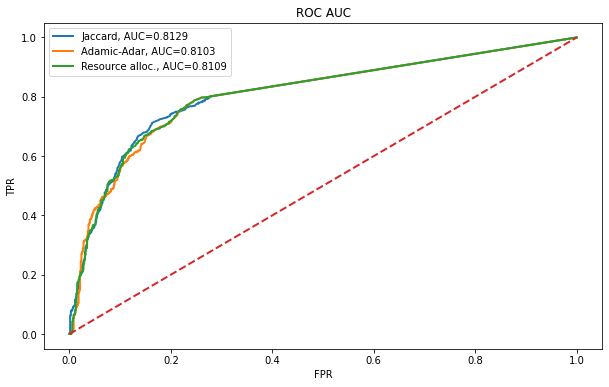

In [144]:
jac, adam, res = sim_link_prediction(train_pos, x_test, y_test)
plt.figure(figsize=(10, 6))
cases = [[jac[0], jac[1], 'Jaccard'], 
         [adam[0], adam[1], 'Adamic-Adar'], 
         [res[0], res[1], 'Resource alloc.']]
for fpr, tpr, label in cases:
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 4. Dot product predictor on node embeddings (2 points)

Similarly to the node classification task, node embeddings could be helpful in the link prediction problem. We can predict a link if two nodes are similar in latent space. One of simple methods to obtain similarity score is using dot product of node embeddings: $$P(A_{i, j}) \propto \langle e_i, e_j \rangle.$$

Here we obtain 16d SVD node embeddings by `sklearn.decompose.TruncatedSVD` on the adjacency matrix.

In [145]:
G = nx.Graph()
G.add_nodes_from(range(np.max(train_pos) + 1))
G.add_edges_from(train_pos)
A = nx.to_numpy_array(G)
model = TruncatedSVD(n_components=16)
emb = model.fit_transform(A)
emb.round(2)

array([[ 0.77, -0.75, -0.45, ..., -0.26,  0.18, -0.19],
       [ 0.04, -0.01, -0.04, ..., -0.01,  0.12,  0.01],
       [ 1.83,  0.95,  0.24, ..., -0.4 ,  0.11, -0.1 ],
       ...,
       [ 0.01, -0.  , -0.01, ...,  0.04,  0.02, -0.04],
       [ 0.14, -0.05, -0.12, ...,  0.12,  0.03, -0.14],
       [ 0.35, -0.3 , -0.37, ..., -0.44,  0.23,  0.05]])

Write a function `dot_product_prediction` that takes node embeddings, test pairs, returns FPR and TPR for the test pairs.

In [158]:
def dot_product_prediction(emb, x_test, y_test):
    node_emb = []
    for x in x_test:
     fnode_e = emb[x[0]]
     snode_e = emb[x[1]]
     score = np.dot(fnode_e, snode_e)
     node_emb.append(score)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, node_emb)
    return fpr,tpr
    
    # YOUR CODE HERE
    #raise NotImplementedError()

In [159]:
fpr, tpr = dot_product_prediction(np.random.random(emb.shape), x_test, y_test)
assert 0.45 < auc(fpr, tpr) < 0.55
fpr, tpr = dot_product_prediction(emb, x_test, y_test)
assert 0.75 < auc(fpr, tpr) < 0.85

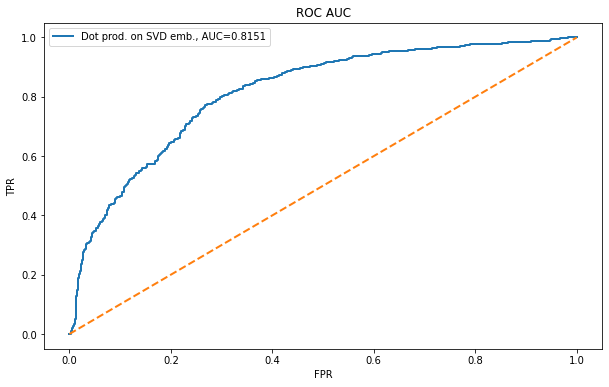

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, 
         label='{}, AUC={:.4f}'.format('Dot prod. on SVD emb.', auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 5. Classification on edge emdeddings (2 points)

Edge emeddings can be used for edge classification by any supervised algorithm (e.g. logistic regression). We can compute edge embeddings using embeddings of adjacent nodes. Let us compare several techniques of a such calculation from the paper: *Makarov I, Gerasimova O, Sulimov P, Zhukov LE. 2019. Dual network embedding for representing research interests in the link prediction problem on co-authorship networks*. Let us use SVD node embeddings for calculating edge embeddings.

In [161]:
G = nx.Graph()
G.add_nodes_from(range(np.max(train_pos) + 1))
G.add_edges_from(train_pos)
A = nx.to_numpy_array(G)
model = TruncatedSVD(n_components=4, random_state=0)
emb = model.fit_transform(A)
emb.round(2)

array([[ 0.77, -0.75, -0.46,  1.53],
       [ 0.04, -0.01, -0.04, -0.03],
       [ 1.83,  0.95,  0.24,  0.33],
       ...,
       [ 0.01, -0.  , -0.01, -0.01],
       [ 0.14, -0.05, -0.12, -0.06],
       [ 0.35, -0.3 , -0.37,  0.85]])

All following functions return edge embeddings for given graph, node embeddings, edges. Average operator is the elementwise average of node embeddings. 
$$
\frac{f(u)+f(v)}{2}
$$
where $f(u)$, $f(v)$ are node embeddings of nodes $u$ and $v$.

In [177]:
def average_operator(G, embeddings, edges):

    r,c = edges.shape
    r2,c2 = embeddings.shape
    output = np.zeros((r,c2))
    for i in range(0,r):
      em_1 = embeddings[edges[i][0]]
      em_2 = embeddings[edges[i][1]]
      for j in range (0,len(em_1)):
        output[i][j] = (em_1[j]+em_2[j])/2
    return output


In [178]:
assert np.allclose(
    average_operator(G, emb, np.array([[42,70]])).round(1),
    [[ 0.6, -0.2, -0.3, -0.2]]
)

Hadamard product is the elementwise product of node embeddings $$f(u) \odot f(v)$$

In [179]:
def hadamard_operator(G, embeddings, edges):
    r,c = edges.shape
    r2,c2 = embeddings.shape
    output = np.zeros((r,c2))
    for i in range(0,r):
      em_1 = embeddings[edges[i][0]]
      em_2 = embeddings[edges[i][1]]
      for j in range (0,len(em_1)):
        output[i][j] = em_1[j]*em_2[j]
    return output
    # YOUR CODE HERE
    #raise NotImplementedError()

In [180]:
assert np.allclose(
    hadamard_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.21, 0.02, 0.09, 0.02]]
)

Weighted L1 is the absolute elementwise difference between node embeddings $$
\left|f(u)-f(v)\right|
$$

In [181]:
def weighted_l1_operator(G, embeddings, edges):
    r,c = edges.shape
    r2,c2 = embeddings.shape
    output = np.zeros((r,c2))
    for i in range(0,r):
      em_1 = embeddings[edges[i][0]]
      em_2 = embeddings[edges[i][1]]
      for j in range (0,len(em_1)):
        output[i][j] = abs(em_1[j]-em_2[j])
    return output
    # YOUR CODE HERE
    #raise NotImplementedError()

In [182]:
assert np.allclose(
    weighted_l1_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.88, 0.12, 0.28, 0.17]]
)

Weighted L2 is the squared elementwise difference between node embeddings $$
\left(f(u)-f(v)\right)^{2}
$$

In [183]:
def weighted_l2_operator(G, embeddings, edges):
    r,c = edges.shape
    r2,c2 = embeddings.shape
    output = np.zeros((r,c2))
    for i in range(0,r):
      em_1 = embeddings[edges[i][0]]
      em_2 = embeddings[edges[i][1]]
      for j in range (0,len(em_1)):
        output[i][j] = (em_1[j]-em_2[j])**2
    return output
    # YOUR CODE HERE
    #raise NotImplementedError()

In [184]:
assert np.allclose(
    weighted_l2_operator(G, emb, np.array([[42,70]])).round(2),
    [[0.77, 0.01, 0.08, 0.03]]
)

Neighbor weighted L1 is the absolute elementwise difference between mean embeddings of nodes neigbors $$
\left|\frac{\sum_{w \in N(u) \cup\{u\}} f(w)}{|N(u)|+1}-\frac{\sum_{t \in N(v) \cup\{v\}} f(t)}{|N(v)|+1}\right|
$$

In [191]:
def neighbor_weighted_l1_operator(G, embeddings, edges):
    r,c = edges.shape
    r2,c2 = embeddings.shape
    output = np.zeros((r,c2))
    for i in range(0,r):
      #first node embeddings
      em_1 = embeddings[edges[i][0]]
      sum1 = np.zeros(em_1.shape)
      sum1 = sum1 + em_1
      N1 = 1
      for Nnode in G.neighbors(edges[i][0]):
        sum1 = sum1 + embeddings[Nnode]
        N1= N1+1
      sum1 = np.true_divide(sum1,N1)
      #seconde node embeddings 
      em_2 = embeddings[edges[i][1]]
      sum2 = np.zeros(em_2.shape)
      sum2 = sum2 + em_2
      N2 = 1
      for Nnode in G.neighbors(edges[i][1]):
        sum2 = sum2 + embeddings[Nnode]
        N2= N2+1
      sum2 = np.true_divide(sum2, N2)
      for j in range (0,len(em_1)):
        output[i][j] = abs(sum1[j]-sum2[j])
    return output
    # YOUR CODE HERE
    #raise NotImplementedError()

In [192]:
assert np.allclose(
    neighbor_weighted_l1_operator(G, emb, np.array([[42,70]])).round(2),
    [[1.89, 0.14, 0.3 , 0.18]]
)

Neighbor weighted L2 is the squared elementwise difference between mean embeddings of nodes neigbors
$$
\left(\frac{\sum_{w \in N(u) \cup\{u\}} f(w)}{|N(u)|+1}-\frac{\sum_{t \in N(v) \cup\{v\}} f(t)}{|N(v)|+1}\right)^{2}
$$

In [193]:
def neighbor_weighted_l2_operator(G, embeddings, edges):
    r,c = edges.shape
    r2,c2 = embeddings.shape
    output = np.zeros((r,c2))
    for i in range(0,r):
      #first node embeddings
      em_1 = embeddings[edges[i][0]]
      sum1 = np.zeros(em_1.shape)
      sum1 = sum1 + em_1
      N1 = 1
      for Nnode in G.neighbors(edges[i][0]):
        sum1 = sum1 + embeddings[Nnode]
        N1= N1+1
      sum1 = np.true_divide(sum1,N1)
      #seconde node embeddings 
      em_2 = embeddings[edges[i][1]]
      sum2 = np.zeros(em_2.shape)
      sum2 = sum2 + em_2
      N2 = 1
      for Nnode in G.neighbors(edges[i][1]):
        sum2 = sum2 + embeddings[Nnode]
        N2= N2+1
      sum2 = np.true_divide(sum2, N2)
      for j in range (0,len(em_1)):
        output[i][j] = (sum1[j]-sum2[j])**2
    return output
    # YOUR CODE HERE
    #raise NotImplementedError()

In [194]:
assert np.allclose(
    neighbor_weighted_l2_operator(G, emb, np.array([[42,70]])).round(2),
    [[3.58, 0.02, 0.09, 0.03]]
)

Now let us look at the ROC AUC for different operators on 16d SVD nome embeddings.

In [195]:
model = TruncatedSVD(n_components=16, random_state=0)
emb = model.fit_transform(A)

operators = {
    "Average": average_operator,
    "Hadamard product": hadamard_operator,
    "Weighted L1": weighted_l1_operator,
    "Weighted L2": weighted_l2_operator,
    "Neighbor weighted L1": neighbor_weighted_l1_operator,
    "Neighbor weighted L2": neighbor_weighted_l2_operator
}

res = dict()
for name, operator in operators.items():
    lr = LogisticRegression()
    train_emb = operator(G, emb, x_train)
    lr.fit(train_emb, y_train)
    test_emb = operator(G, emb, x_test)
    y_pred = lr.predict_proba(test_emb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    res[name] = {
        'fpr': fpr,
        'tpr': tpr
    }

assert auc(fpr, tpr) > 0.75

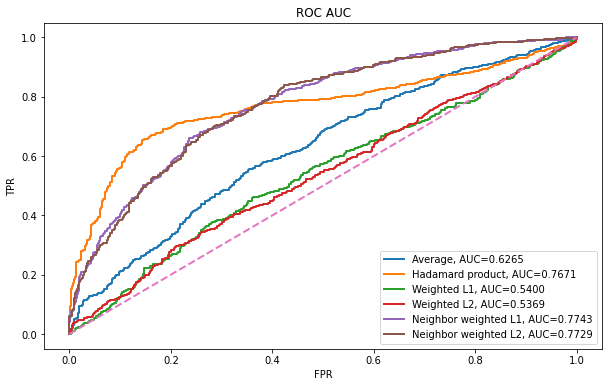

In [196]:
plt.figure(figsize=(10, 6))
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()